# Visualize and analyze data

## Package imports

In [1]:
import sys

# installing needed packages - this may take a few minutes
#!conda install -c conda-forge --yes --prefix {sys.prefix} laspy
try:
    import shapely
    import shapely.geometry
    import folium
except ModuleNotFoundError:
    !conda install --yes --prefix {sys.prefix} shapely
    !conda install --yes --prefix {sys.prefix} folium
    import shapely
    import shapely.geometry
    import folium


try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !conda install --yes --prefix {sys.prefix} matplotlib
    import matplotlib.pyplot as plt
#import laspy
import numpy as np

sys.path.append("..")
from pytreedb import db

## Import database

Define (local) MongoDB connection and import database from URL

In [2]:
mydbfile = "my_pytree.db"
db_url = "https://github.com/3dgeo-heidelberg/pytreedb/raw/main/data/test/data.db"
mydb = db.PyTreeDB(dbfile=mydbfile)
mydb.import_db(db_url, overwrite=True)

Download from: https://github.com/3dgeo-heidelberg/pytreedb/raw/main/data/test/data.db
1491 trees synchronized with MongoDB server.


1491

## Show data on a map

First, let's query the database and select only trees for which terrestrial laser scanning (TLS) data is available. 

In [ ]:
res = mydb.query({"properties.data.mode": "TLS"})

To display the filtered trees on the map, we retrieve their locations, their IDs and their species.

In [ ]:
tree_locations = [tree["geometry"]["coordinates"] for tree in res]
tree_ids = [tree["properties"]["id"] for tree in res]
tree_species = [tree["properties"]["species"] for tree in res]

You can zoom in and click on the markers in the map created below to read out the ID and species of the respective tree.

In [ ]:
tooltip = "Click me!"
m = folium.Map([49.0077, 8.702], zoom_start=13)
for point, name, species in zip(tree_locations, tree_ids, tree_species):
    html = f"""
    <strong>{name}</strong><br>
    <em>{species}</em>
    """
    # note that we have to reverse latitude and longitude
    folium.Marker(point[1::-1], popup=html, tooltip=tooltip).add_to(m)
m

In [ ]:
tooltip = "Click me!"
m = folium.Map([49.0299, 8.4382], zoom_start=14)
for point, name, species in zip(tree_locations, tree_ids, tree_species):
    html = f"""
    <strong>{name}</strong><br>
    <em>{species}</em>
    """
    # note that we have to reverse latitude and longitude
    folium.Marker(point[1::-1], popup=html, tooltip=tooltip).add_to(m)
m

## Bar plots and Histograms

Plot the number of available trees for each data source as a bar plot

In [103]:
data = {
    "ALS": len(mydb.query({"properties.data.mode": "ALS"})),
    # "$elemMatch" operator to specify multiple criteria on an array element.
    "ULS leaf-on": len(
        mydb.query({"properties.data": {"$elemMatch": {"mode": "ULS", "canopy_condition": "leaf-on"}}})
    ),
    "ULS leaf-off": len(
        mydb.query({"properties.data": {"$elemMatch": {"mode": "ULS", "canopy_condition": "leaf-off"}}})
    ),
    "TLS": len(mydb.query({"properties.data.mode": "TLS"})),
}

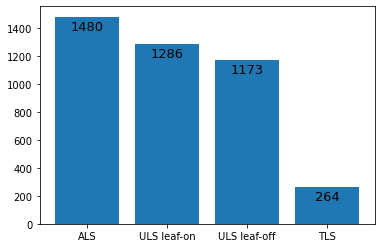

In [104]:
names = list(data.keys())
values = list(data.values())

plots = plt.bar(range(len(data)), values, tick_label=names)
for bar in plots.patches:
    plt.annotate(
        format(bar.get_height(), "d"),
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="center",
        size=13,
        xytext=(0, -10),
        textcoords="offset points",
    )
plt.show()

Plot a histogram of tree heights (measured from ALS data)

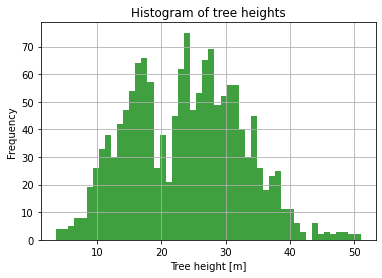

In [44]:
ALS_meas = [meas_dict for tree in mydb.db for meas_dict in tree["properties"]["measurements"] if "source" in meas_dict.keys() and meas_dict["source"] == "ALS"]
tree_heights_ALS = np.array([meas_dict["height_m"] for meas_dict in ALS_meas])

# the histogram of the data
n, bins, patches = plt.hist(tree_heights_ALS, 50, facecolor='g', alpha=0.75)

plt.xlabel('Tree height [m]')
plt.ylabel('Frequency')
plt.title('Histogram of tree heights')
plt.grid(True)
plt.show()

## Scatter plot of metrics

Scatter plots of metrics obtained from different sources

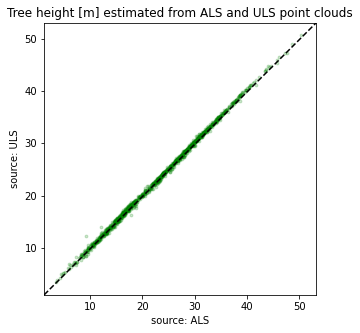

In [81]:
res = mydb.query({"$and": [{"properties.data.mode": "ALS"}, {"properties.data.mode": "ULS"}]})
ULS_meas = [meas_dict for tree in res for meas_dict in tree["properties"]["measurements"] if "source" in meas_dict.keys() and meas_dict["source"] == "ULS" and meas_dict["canopy_condition"] == "leaf-on"]
ALS_meas = [meas_dict for tree in res for meas_dict in tree["properties"]["measurements"] if "source" in meas_dict.keys() and meas_dict["source"] == "ALS" and meas_dict["canopy_condition"] == "leaf-on"]
tree_heights_ULS = np.array([meas_dict["height_m"] for meas_dict in ULS_meas])
tree_heights_ALS = np.array([meas_dict["height_m"] for meas_dict in ALS_meas])

fig, ax = plt.subplots(figsize=(5, 5))
# scatter plot of tree heights from different sources
ax.scatter(tree_heights_ALS, tree_heights_ULS, s=8.0, alpha=0.2, color="green")
# plot diagonal
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black", ls="--", lw=1.5)
plt.xlabel("source: ALS")
plt.ylabel("source: ULS")
plt.title("Tree height [m] estimated from ALS and ULS point clouds")

plt.axis('square')
plt.show()

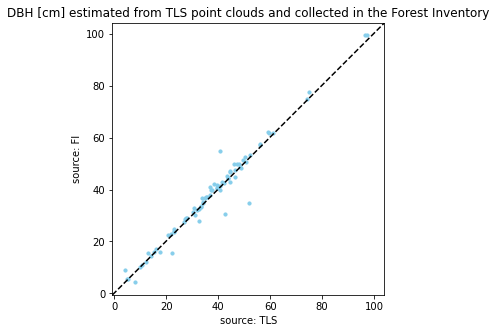

In [91]:
res = mydb.query({"$and": [{"properties.measurements.source": "TLS"}, {"properties.measurements.source": "FI"}]})
TLS_meas = [meas_dict for tree in res for meas_dict in tree["properties"]["measurements"] if "source" in meas_dict.keys() and meas_dict["source"] == "TLS"]
FI_meas = [meas_dict for tree in res for meas_dict in tree["properties"]["measurements"] if "source" in meas_dict.keys() and meas_dict["source"] == "FI"]
DBH_TLS = np.array([meas_dict["DBH_cm"] for meas_dict in TLS_meas])
DBH_FI = np.array([meas_dict["DBH_cm"] for meas_dict in FI_meas])

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(DBH_TLS, DBH_FI, s=10, alpha=1.0, color="skyblue")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black", ls="--", lw=1.5)
plt.xlabel("source: TLS")
plt.ylabel("source: FI")
plt.title("DBH [cm] estimated from TLS point clouds and collected in the Forest Inventory")

plt.axis('square')
plt.show()

Plot DBH against tree height

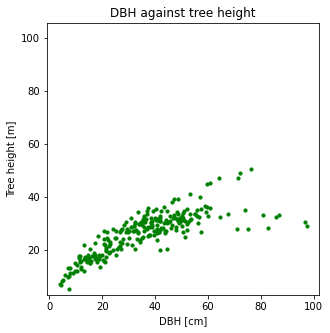

In [102]:
# "$elemMatch" operator to specify multiple criteria on an array element.
# the query returns trees which have both a) TLS measurements and b) leaf-on ULS measurements
res = mydb.query({"$and": [{"properties.measurements.source": "TLS"}, 
                           {"properties.measurements": { "$elemMatch": {"source": "ULS", "canopy_condition": "leaf-on"}}}]})
TLS_meas = [meas_dict for tree in res for meas_dict in tree["properties"]["measurements"] if "source" in meas_dict.keys() and meas_dict["source"] == "TLS"]
ULS_meas = [meas_dict for tree in res for meas_dict in tree["properties"]["measurements"] if "source" in meas_dict.keys() and meas_dict["source"] == "ULS" and meas_dict["canopy_condition"] == "leaf-on"]

dbh = np.array([meas_dict["DBH_cm"] for meas_dict in TLS_meas])
height = np.array([meas_dict["height_m"] for meas_dict in ULS_meas])

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(dbh, height, s=10, alpha=1.0, color="green")
plt.xlabel("DBH [cm]")
plt.ylabel("Tree height [m]")
plt.title("DBH against tree height")

plt.axis('square')
plt.show()

Compare crown diameter to tree height ratio for different species

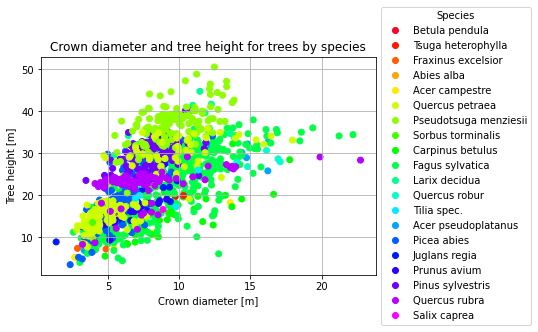

In [135]:
res = mydb.query({"properties.measurements": { "$elemMatch": {"source": "ULS", "canopy_condition": "leaf-on", "height_m": {"$exists": True}, "mean_crown_diameter_m": {"$exists": True}}}})
tree_species = [tree["properties"]["species"] for tree in res]
height = [meas_dict["height_m"] for tree in res for meas_dict in tree["properties"]["measurements"] if "source" in meas_dict.keys() and meas_dict["source"] == "ULS" and meas_dict["canopy_condition"] == "leaf-on"]
diam = [meas_dict["mean_crown_diameter_m"] for tree in res for meas_dict in tree["properties"]["measurements"] if "source" in meas_dict.keys() and meas_dict["source"] == "ULS" and meas_dict["canopy_condition"] == "leaf-on"]

num_colors = len(set(tree_species))
cm = plt.get_cmap("gist_rainbow")
my_colors = [cm(1.*i/num_colors) for i in range(num_colors)]

my_color_dict = {}
for i, species in enumerate(set(tree_species)):
    my_color_dict[species] = my_colors[i]

scatter = plt.scatter(diam, height, c=[my_color_dict[i] for i in tree_species])
plt.xlabel("Crown diameter [m]")
plt.ylabel("Tree height [m]")
plt.title("Crown diameter and tree height for trees by species")
plt.grid(True)
# generate custom fake lines that will be used as legend entries
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in my_color_dict.values()]
plt.legend(markers, my_color_dict.keys(), numpoints=1, title = "Species", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 3D plots of point clouds

In [ ]:
# pypotree / PPTK / Open3D / PyntCloud / matplotlib ?